## Introduction

This notebook runs a couple of analyses on the original data and the predictions from the transformer model.
It can be run both locally and on snellius. When the [jupytext](https://jupytext.readthedocs.io/en/latest/) is installed,
this file `analyze_predictions.ipynb` syncs automatically with the script `analyze_predictions.py`.

### How to run on Snellius
The script `analyze_predictions.py` can be run on Snellius as follows.
```bash
$ sbatch analyze_predictions.sh

# sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
# sbatch: A full node consists of 72 CPU cores, 491520 MiB of memory and 4 GPUs and can be shared by up to 4 jobs.
# sbatch: By default shared jobs get 6826 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
# sbatch: You will be charged for 1 GPUs, based on the number of CPUs, GPUs and the amount memory that you've requested.
# Submitted batch job 7740229



In [1]:
import numpy as np
import h5py
from dask import array as da
import matplotlib.pyplot as plt
import seaborn as sns
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
from pathlib import Path
import os
import sys
%matplotlib inline

In [2]:
PLOTS_DIR = Path("plots")
DATA_DIR = Path("data")

In [3]:
# The shell script version of this analysis can take chunksize as an argument.
# When running as a shell script it is also assumed that the analysis needs to be run on the full dataset.

try:
    print(sys.argv)
    chunksize = int(sys.argv[1])
    sample_size = -1
    print(f"Found chunksize of {chunksize}")
except Exception:
    print("No chunksize found")
    chunksize = 1000
    sample_size = 1000

print(f"chunksize: {chunksize}, sample size: {sample_size}")

['/home/dsmits/.cache/pypoetry/virtualenvs/aiproteomics-MPvhd94L-py3.10/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/dsmits/.local/share/jupyter/runtime/kernel-e38543bc-56b4-4130-a207-f5dbcac39d65.json']
No chunksize found
chunksize: 1000, sample size: 1000


In [4]:
def load_dask_array_from_hdf5(filename, key, chunksize=1000, sample_size=-1):
    """
    Load data from hdf5 files and convert it to a dask array.
    Dask uses lazy loading so chunksize ensures that only a limited amount of data
    is loaded at any time.

    Parameters:
        filename: the hdf5 file
        key: the key to the specific array
        chunksize: chunksize of the array. Default is 1000
        sample_size: the amount of samples to load. Default is to load the full dataset

    Returns:
        array: a dask array
    """
    
    f = h5py.File(filename)
    a = da.from_array(f[key], chunks=chunksize)
    a = a[:sample_size]
    return a

In [5]:
predictions = load_dask_array_from_hdf5(DATA_DIR/"predictions.hdf5", "predictions", chunksize, sample_size)
labels = load_dask_array_from_hdf5(DATA_DIR/"traintest_hcd.hdf5", "intensities_raw", chunksize, sample_size)
collision_energy = load_dask_array_from_hdf5(DATA_DIR/"traintest_hcd.hdf5", "collision_energy", chunksize, sample_size)
precursor_charge = load_dask_array_from_hdf5(DATA_DIR/"traintest_hcd.hdf5", "precursor_charge_onehot", chunksize, sample_size)
sequences = load_dask_array_from_hdf5(DATA_DIR/"traintest_hcd.hdf5", "sequence_integer", chunksize, sample_size)

In [27]:
# Calculating sequence length by finding the first occurrence of 0
sequence_lengths= da.argmin(sequences, axis=1)

# Full sequences have no 0s so we have to do something different.
full_sequences = sequences[:,-1] > 0
full_sequences.shape

# Fix the lengths of the full sequences
sequence_lengths[full_sequences] = 29

In [7]:
f = h5py.File(DATA_DIR/"traintest_hcd.hdf5")

f.keys()

<KeysViewHDF5 ['collision_energy', 'collision_energy_aligned', 'collision_energy_aligned_normed', 'intensities_raw', 'masses_pred', 'masses_raw', 'method', 'precursor_charge_onehot', 'rawfile', 'reverse', 'scan_number', 'score', 'sequence_integer', 'sequence_onehot']>

In [8]:
labels.shape

(1000, 174)

In [9]:
predictions.shape

(1000, 174)

In [10]:
labels[0].compute()

array([ 0.03333019,  0.        ,  0.        ,  0.00833965,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.39771285,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.12638215,  0.        ,  0.        ,  0.00881359,  0.        ,
        0.        ,  0.0085394 ,  0.        ,  0.        ,  0.02134586,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01633287,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.01483933,  0.        ,  0.02334369,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00457667,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00765157,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.02404616,  0.        ,  0.  

In [11]:
from sklearn.preprocessing import normalize


# TODO: Check if results are the same as with ComparisonPrositFrag
def normalized_spectral_contrast_distance(true, pred):
    """
    Calculate the (normalized) spectral contrast distance for two spectra. 1 represents total overlap.
    """
    pred_norm = normalize(pred)
    true_norm = normalize(true)
    
    product =  pred_norm * true_norm
    product = product.sum(axis=1)
    
    arccos = np.arccos(product)
    return 1 - 2 * arccos / np.pi



In [12]:
normalized_spectral_contrast_distance(labels[:2], predictions[:2])

/home/dsmits/.cache/pypoetry/virtualenvs/aiproteomics-MPvhd94L-py3.10/lib/python3.10/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home/dsmits/.cache/pypoetry/virtualenvs/aiproteomics-MPvhd94L-py3.10/lib/python3.10/site-packages/dask/array/core.py:1705: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


array([ 0.06520899, -0.05064844])

In [13]:
limit=None

comparisons = da.map_blocks(normalized_spectral_contrast_distance, labels[:limit], predictions[:limit], drop_axis=1, dtype=float)

comparisons

dask.array<normalized_spectral_contrast_distance, shape=(1000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

In [14]:
computation, edges = da.histogram(comparisons, bins=50, range=(0, 1))

with ProgressBar():
    hist = computation.compute()

[########################################] | 100% Completed | 101.89 ms


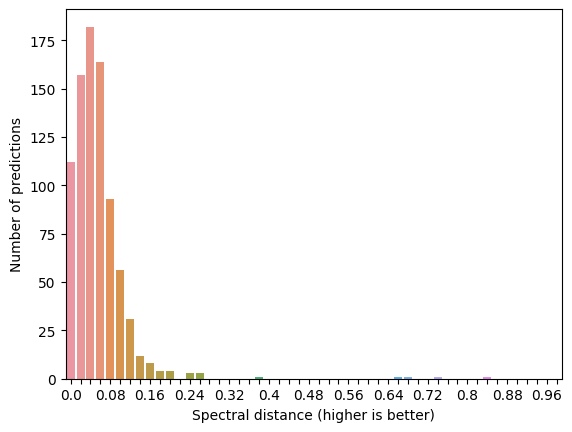

In [15]:


ax = sns.barplot(x=edges[:-1], y=hist)

_=ax.set_xticks(ticks = range(len(edges[:-1])), labels=[e if i%4 == 0 else "" for i, e in enumerate(edges[:-1])])
_ = ax.set_xlabel("Spectral distance (higher is better)")
_ = ax.set_ylabel("Number of predictions")

plt.savefig(PLOTS_DIR/"accuracy_hist.png")

In [16]:
sequence_column_names = [f"seq_{i}" for i in range(sequences.shape[1])]

sequence_df = dd.from_dask_array(sequences, columns=sequence_column_names)

concatenated = dd.concat([dd.from_dask_array(sequence_lengths), dd.from_dask_array(collision_energy), dd.from_dask_array(comparisons), sequence_df], 1)
concatenated.columns = ["sequence_length", "collision_energy", "distance"] + sequence_column_names

concatenated

Dask DataFrame Structure:
              sequence_length collision_energy distance  seq_0  seq_1  seq_2  seq_3  seq_4  seq_5  seq_6  seq_7  seq_8  seq_9 seq_10 seq_11 seq_12 seq_13 seq_14 seq_15 seq_16 seq_17 seq_18 seq_19 seq_20 seq_21 seq_22 seq_23 seq_24 seq_25 seq_26 seq_27 seq_28 seq_29
npartitions=1                                                                                                                                                                                                                                                            
0                       int64          float64  float64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64  int64
999                       ...              ...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
Dask Name: rename, 2 graph layers

In [17]:
concatenated.head()

sequence_length  collision_energy  distance  seq_0  seq_1  seq_2  seq_3  \
0               19              30.0  0.065209     19      4     18     20   
1               12              20.0 -0.050648     10     13     12      5   
2               13              35.0  0.055116      3      1      3     18   
3               11              23.0  0.058689      3     10     10     14   
4               12              25.0  0.085183      4      4      6     20   

   seq_4  seq_5  seq_6  ...  seq_20  seq_21  seq_22  seq_23  seq_24  seq_25  \
0     13     18     12  ...       0       0       0       0       0       0   
1     10      4     10  ...       0       0       0       0       0       0   
2     14     12      5  ...       0       0       0       0       0       0   
3     10      6      6  ...       0       0       0       0       0       0   
4      3     16     18  ...       0       0       0       0       0       0   

   seq_26  seq_27  seq_28  seq_29  
0       0       0       0       0  
1       0       0       0       0  
2       0       0       0       0  
3       0       0       0       0  
4       0       0       0       0  

[5 rows x 33 columns]

[########################################] | 100% Completed | 101.92 ms


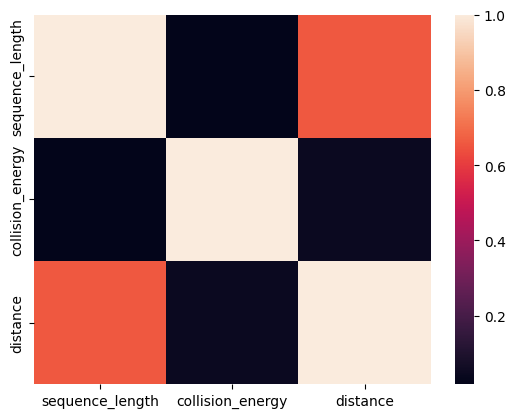

In [18]:
corr_columns = ["sequence_length", "collision_energy", "distance"]

with ProgressBar():
    correlations = concatenated[corr_columns].corr().compute()

sns.heatmap(correlations)

plt.savefig(PLOTS_DIR/"correlations")

It seems that sequence length and distance have some correlation. I can imagine that longer sequences are more easy to predict because there is more info there? Or maybe there are unique sequences that are memorized. I wonder what the distribution is of sequence length.

In [19]:
freq, bins = da.histogram(concatenated["sequence_length"], bins=range(30))

with ProgressBar():
    freq = freq.compute()
    
bins = bins.compute()

[########################################] | 100% Completed | 101.87 ms


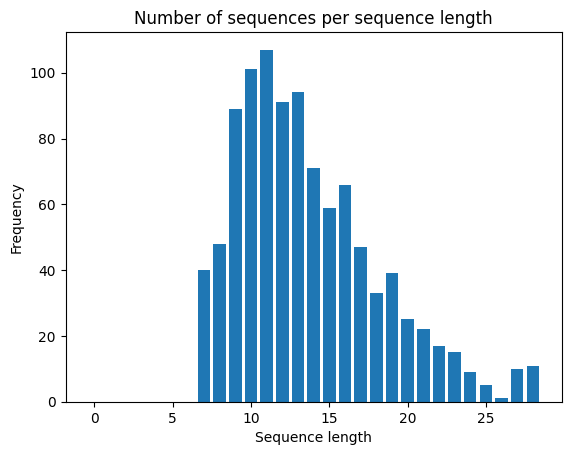

In [20]:
fig, ax = plt.subplots()

ax.bar(x=range(freq.shape[0]), height= freq)
ax.set_xlabel("Sequence length")
ax.set_ylabel("Frequency")

ax.set_title("Number of sequences per sequence length")

plt.savefig(PLOTS_DIR/"sequence_length_histogram.png")

I wonder if there are any duplicates and whether it is possible that the model overfits on them.

In [21]:
counts = sequence_df.groupby(sequence_df.columns.tolist()).size()


counts[counts["size"] > 1]

with ProgressBar():
    counts =  counts.compute()



[########################################] | 100% Completed | 101.63 ms


Looks like there is one sequence that is in the dataset 2843 times! I wonder how that affects the training set. I also wonder if this sequence has consistent target values.

In [22]:
sorted_duplicates = counts.sort_values(ascending=False)

pd.DataFrame(sorted_duplicates, columns=["number_of_duplicates"])

number_of_duplicates
seq_0 seq_1 seq_2 seq_3 seq_4 seq_5 seq_6 seq_7 seq_8 seq_9 seq_10 seq_11 seq_12 seq_13 seq_14 seq_15 seq_16 seq_17 seq_18 seq_19 seq_20 seq_21 seq_22 seq_23 seq_24 seq_25 seq_26 seq_27 seq_28 seq_29                      
7     19    20    8     17    17    6     13    18    15    4      9      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          2
10    10    16    18    6     15    1     3     10    1     9      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          2
14    1     3     7     10    6     16    14    1     5     20     13     6      15     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
      7     16    13    6     16    1     3     16    10    16     12     3      16     14     15     0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
      6     17    6     19    12    10    18    9     16    0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
...                                                                                                                                                                                                                       ...
7     16    12    10    10    20    18    12    18    8     6      10     1      3      3      16     18     15     0      0      0      0      0      0      0      0      0      0      0      0                          1
            16    14    8     4     6     18    15    0     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
      17    5     20    6     8     4     16    7     15    0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
      18    1     17    16    16    6     10    20    10    14     12     8      17     14     15     0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1
21    18    18    3     5     2     15    0     0     0     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0                          1

[998 rows x 1 columns]

In [23]:
with ProgressBar():
    all_duplicates = concatenated[(concatenated[sequence_column_names] == sorted_duplicates.index[0]).all(axis=1)].compute()

all_duplicates

all_duplicates.to_csv(PLOTS_DIR/"duplicates.csv")

[########################################] | 100% Completed | 101.95 ms


## Distinguishing samples that perform well or badly



In [24]:
concatenated.head()

sequence_length  collision_energy  distance  seq_0  seq_1  seq_2  seq_3  \
0               19              30.0  0.065209     19      4     18     20   
1               12              20.0 -0.050648     10     13     12      5   
2               13              35.0  0.055116      3      1      3     18   
3               11              23.0  0.058689      3     10     10     14   
4               12              25.0  0.085183      4      4      6     20   

   seq_4  seq_5  seq_6  ...  seq_20  seq_21  seq_22  seq_23  seq_24  seq_25  \
0     13     18     12  ...       0       0       0       0       0       0   
1     10      4     10  ...       0       0       0       0       0       0   
2     14     12      5  ...       0       0       0       0       0       0   
3     10      6      6  ...       0       0       0       0       0       0   
4      3     16     18  ...       0       0       0       0       0       0   

   seq_26  seq_27  seq_28  seq_29  
0       0       0       0       0  
1       0       0       0       0  
2       0       0       0       0  
3       0       0       0       0  
4       0       0       0       0  

[5 rows x 33 columns]

In [25]:
with ProgressBar():
    best_performing = concatenated.sort_values("distance", ascending=False).head(1000)

best_performing

[########################################] | 100% Completed | 101.48 ms


sequence_length  collision_energy  distance  seq_0  seq_1  seq_2  seq_3  \
635               29              35.0  0.845350     11     11     14     14   
236               29              25.0  0.745997      6      4      2     16   
769               29              28.0  0.693593     11      1      3      7   
775               29              35.0  0.671265     10      8      7     16   
948               29              35.0  0.393569      1     12     10      1   
..               ...               ...       ...    ...    ...    ...    ...   
35                 7              28.0 -0.119843      9     13      3      3   
316               11              35.0 -0.128245     20     13      4      9   
962               13              25.0 -0.141196      8      6     17      6   
115               13              23.0 -0.148923     20     13      4     11   
804               11              23.0 -0.188335     12     13     21      1   

     seq_4  seq_5  seq_6  ...  seq_20  seq_21  seq_22  seq_23  seq_24  seq_25  \
635     13     15     18  ...       1      18      13      19      16       1   
236     13     13      6  ...      10      16      13      20      13       2   
769     10     11     10  ...       1       1       1       7       6      13   
775      6     16     16  ...      13      20      17       6      10       9   
948     10     13     14  ...      16      13      14       4      18      16   
..     ...    ...    ...  ...     ...     ...     ...     ...     ...     ...   
35       8     13     15  ...       0       0       0       0       0       0   
316      4     16      4  ...       0       0       0       0       0       0   
962     16      5      6  ...       0       0       0       0       0       0   
115      3     10      3  ...       0       0       0       0       0       0   
804      4     12     16  ...       0       0       0       0       0       0   

     seq_26  seq_27  seq_28  seq_29  
635      19      18      17      15  
236      13       1      13       9  
769       7       1      10      15  
775       1       3      12      15  
948      16       6      15       0  
..      ...     ...     ...     ...  
35        0       0       0       0  
316       0       0       0       0  
962       0       0       0       0  
115       0       0       0       0  
804       0       0       0       0  

[1000 rows x 33 columns]

In [26]:
best_performing.iloc[0]

sequence_length     29.00000
collision_energy    35.00000
distance             0.84535
seq_0               11.00000
seq_1               11.00000
seq_2               14.00000
seq_3               14.00000
seq_4               13.00000
seq_5               15.00000
seq_6               18.00000
seq_7                4.00000
seq_8               17.00000
seq_9                3.00000
seq_10              17.00000
seq_11               8.00000
seq_12               6.00000
seq_13               1.00000
seq_14               6.00000
seq_15               4.00000
seq_16               6.00000
seq_17              13.00000
seq_18              14.00000
seq_19              14.00000
seq_20               1.00000
seq_21              18.00000
seq_22              13.00000
seq_23              19.00000
seq_24              16.00000
seq_25               1.00000
seq_26              19.00000
seq_27              18.00000
seq_28              17.00000
seq_29              15.00000
Name: 635, dtype: float64